In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from glob import glob
import shutil
import sys
import os

OUTDIR = "./"

# Define consistent naming and styles

In [2]:
def algStepWise(suf,suff=""):
    return r"$\mathsf{Seq}_\mathsf{%s}^\mathsf{%s}$" % (suf, suff)

def renameSim(algo):
    return {
        "batch":             r"$\mathsf{MultiBatched}$",
        "distr-alias-fixed": algStepWise("Alias"),
        "distr-linear":      algStepWise("Linear"),
        "distr-tree":        algStepWise("BST"),
        "pop":               algStepWise("Array"),
        "pop8":              algStepWise("Array", "prefetch"),
    }[algo]

def styleSim(algo):
    algos = ["batch", "distr-alias-fixed", "distr-linear", "distr-tree", "pop", "pop8"]
    style = ['-', '--', ':', '-.', '-', '--']
    ind = algos.index(algo)
    return {'color': "C%d" % ind, 'linestyle': style[ind]}

def renameProtocol(prot):
    return {
        "clock": "Uniform Clock",
        "running-clock": "Running Clock",
        "random2": "Random Two-Way"
    }[prot]


def add_sublegend(fig, axs):
    fig.subplots_adjust(bottom=0.25) 
    shape = list(axs.shape)
    ind = tuple([x - 1 for x in shape[:-1]] + [shape[-1] // 2])
    ax = axs[ind] 
    ax.legend(ncol=6, loc='upper center',  bbox_to_anchor=(0.5 if shape[-1] % 2 == 1 else 0, -0.2),fancybox=False, shadow=False)

# Import raw data

We concatenate the files produced by parallel runs and add a thread column

In [3]:
def cat_data(in_path, out_path):
    prefixes = glob(os.path.join(in_path, "*-"))
    data_frames = []
    threads = None
    
    for p in prefixes:
        files = sorted(glob(p + "*.csv"))
    
        if False and len(files) == 1:
            data_frames.append(pd.read_csv(files[0]))
            threads = 1
            continue

        t = max(1, len(files))
        assert(threads is None or threads == t)
        threads = t
        
        with open(p, "r") as f:
            headers = f.readline().strip().split(",")
    
        for f in files:
            data_frames.append(pd.read_csv(f, names=headers))
    
    if not prefixes:
        threads = 1
        files = glob(os.path.join(in_path, "*.csv"))
        assert(len(files) == 1)
        data_frames.append(pd.read_csv(files[0]))
    
    if (len(data_frames) == 1):
        data = data_frames[0]
    else:
        data = pd.concat(data_frames)
        
    data["threads"] = threads
    data.to_csv(out_path)
            
for dir in glob("data/threaded_raw/benchmark*"):
    if not os.path.isdir(dir): continue
    cat_data(dir, os.path.join("data", "threaded_" + os.path.basename(dir) + ".csv.bz2"))

# Load data

In [4]:
data = pd.concat( [pd.read_csv(f) for f in glob("data/threaded_benchmark_th*.csv.bz2")] )
data = data[data.num_agents > 32000]
data = data[data.simulator != "distr-alias"]
data = data[data.threads != 20]
data["int_time"] = 1e9 * data.walltime / data.num_interactions# / data.threads
#data["int_time"] = data.walltime #/ data.num_interactions# / data.threads

def plot_benchmark(data, protocol, num_states, threads, ax, incl_bench, incl_xlabels, incl_ylabels, timeout = 600):
        maxx = 0
        for sim, sview in data.groupby("simulator"):
            if not incl_bench and "batch" in sim: 
                continue
                
            grp = sview.groupby("num_agents")
            ys     = grp.int_time.median()
            ys_err = grp.int_time.std()
            
            xs     = ys.index.to_numpy()
            mask   = (grp.walltime.median() < timeout) # & ((grp.int_time.size() >= mss) | (xs < 2**28))
            
            ax.errorbar(xs[mask], ys[mask], ys_err[mask], label=renameSim(sim), **styleSim(sim))
            maxx = max(maxx, np.max(xs[mask]))
        
        ax.grid()
        ax.set_title("%s: $|Q| = %d$, %d thread%s" % (renameProtocol(protocol), num_states, threads, "s" if threads > 1 else ""))
        ax.set_xlim(2**15, maxx*2)
        
        if incl_xlabels:
            ax.set_xlabel("Number $n$ of agents")
        
        if incl_ylabels:
            ax.set_ylabel("Time per interaction [ns]")
            
        if incl_bench:
            ax.loglog(basex=2)
        else:
            ax.semilogx(basex=2)

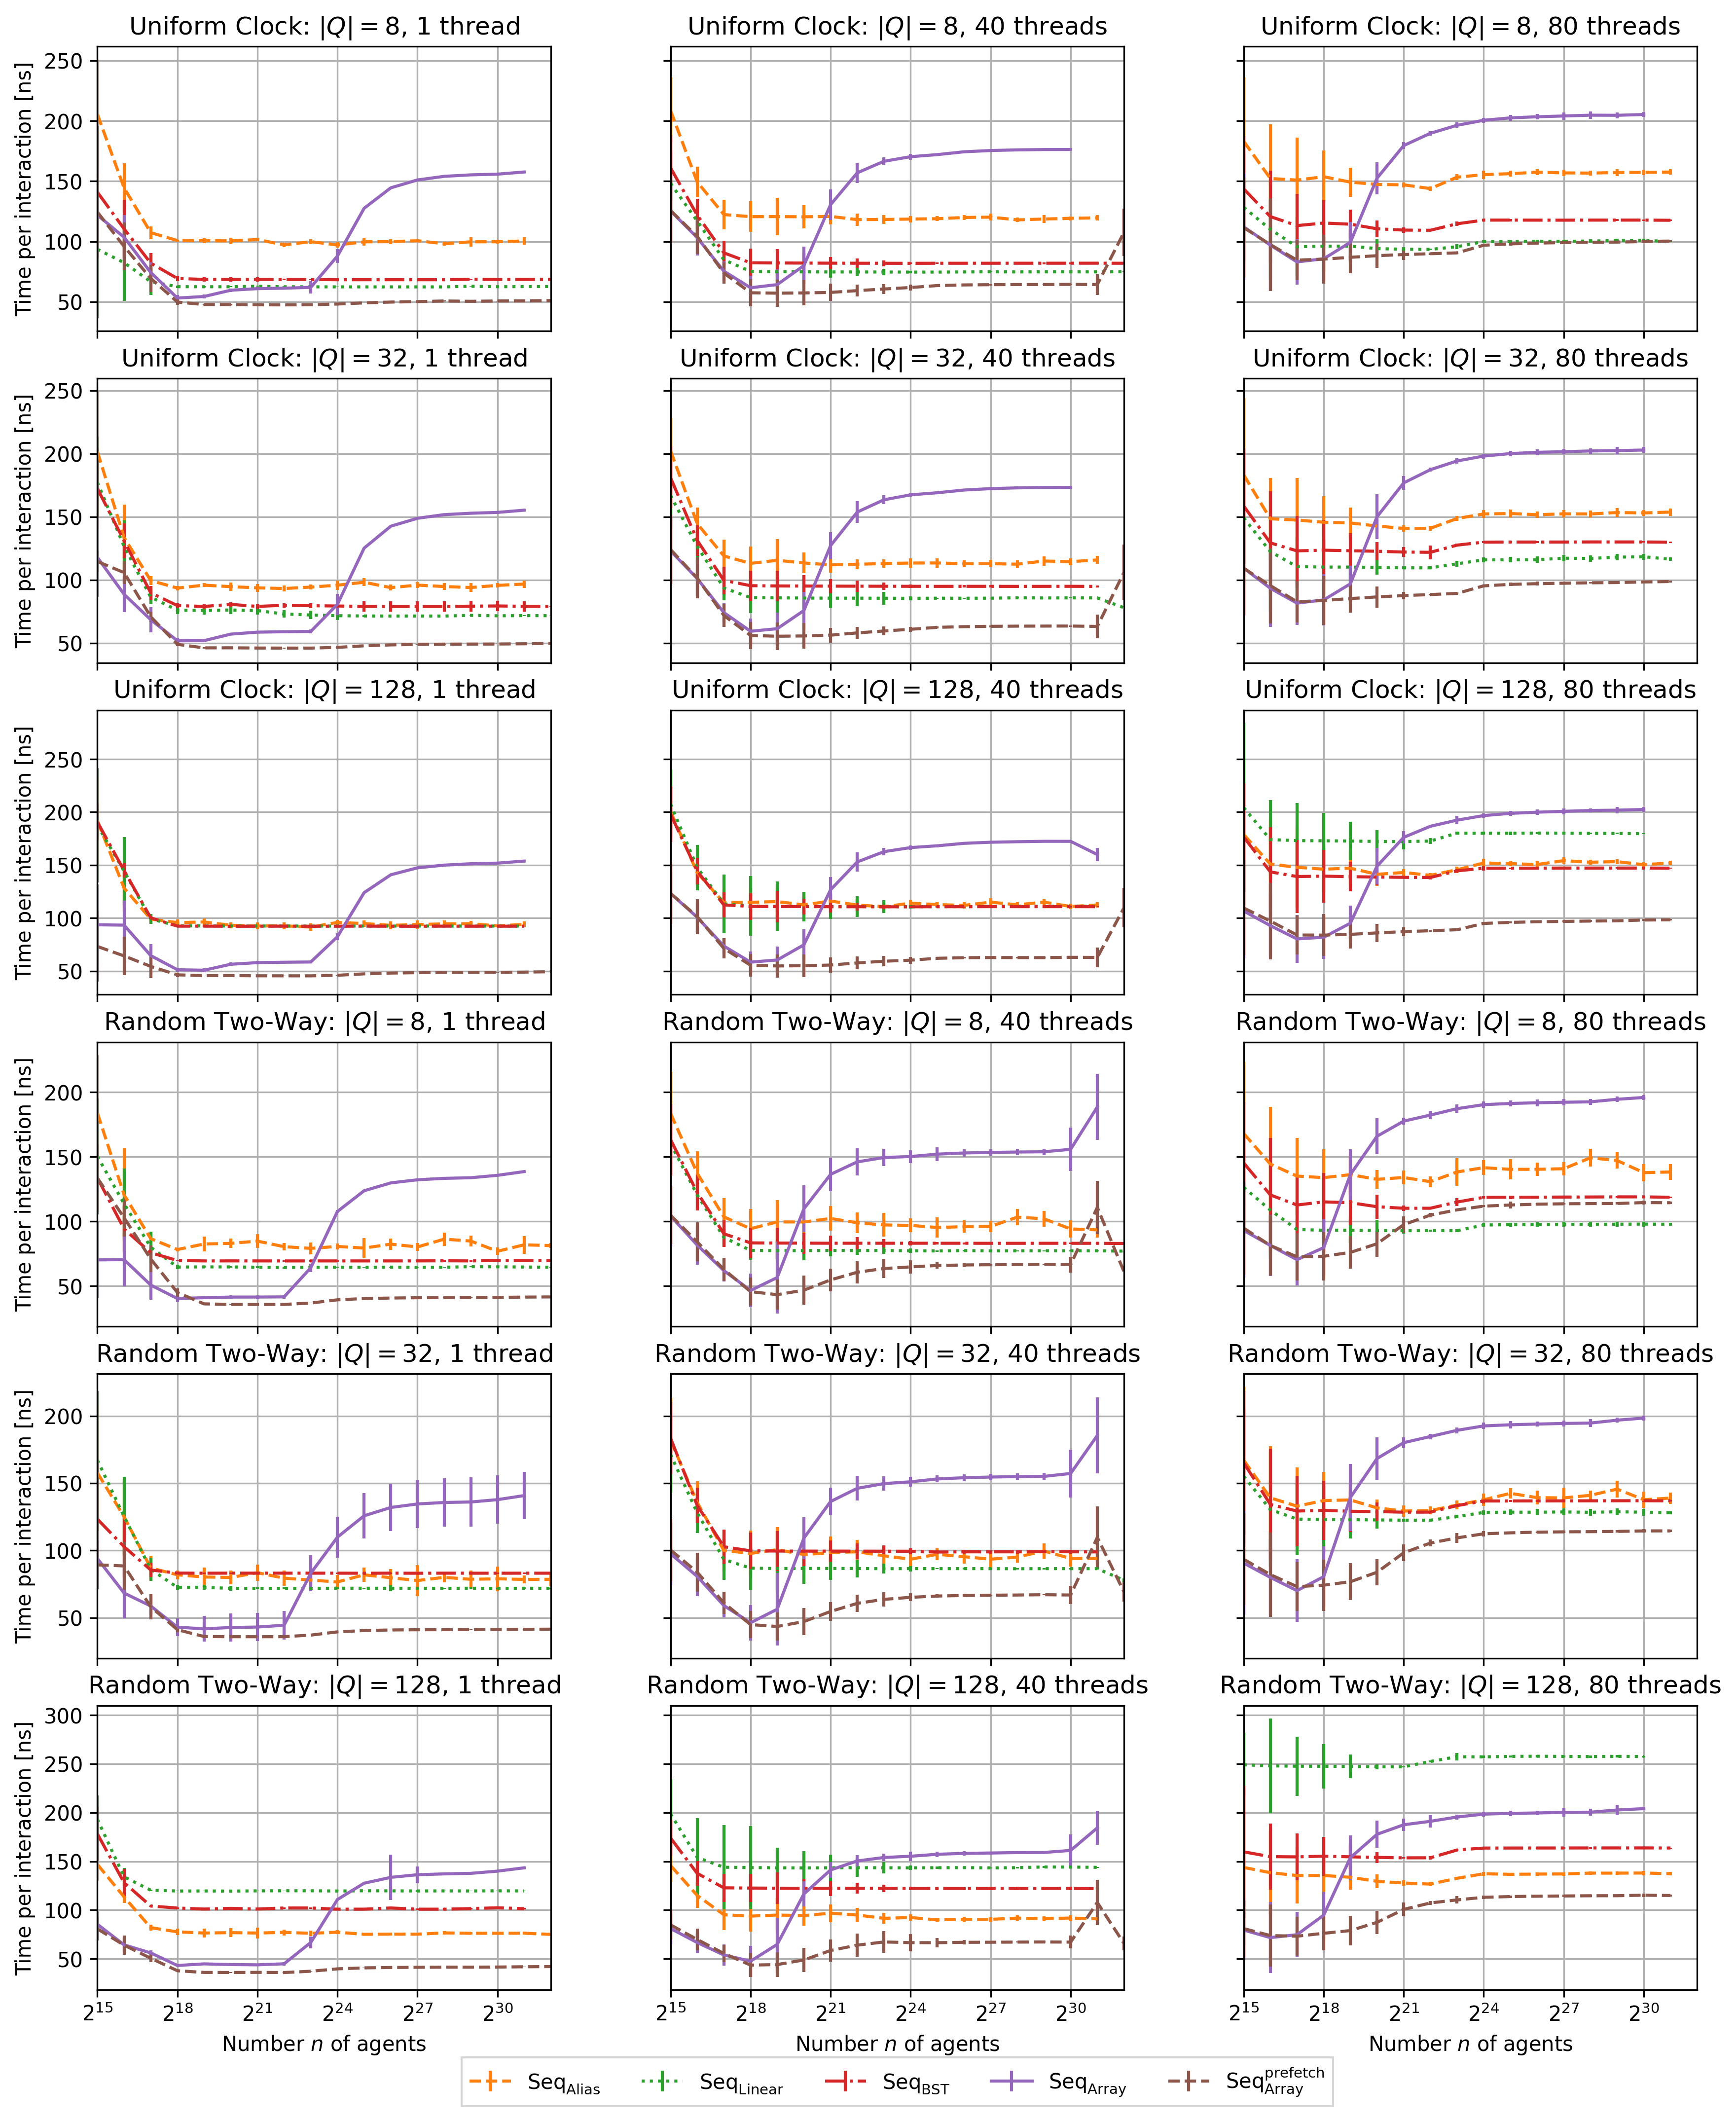

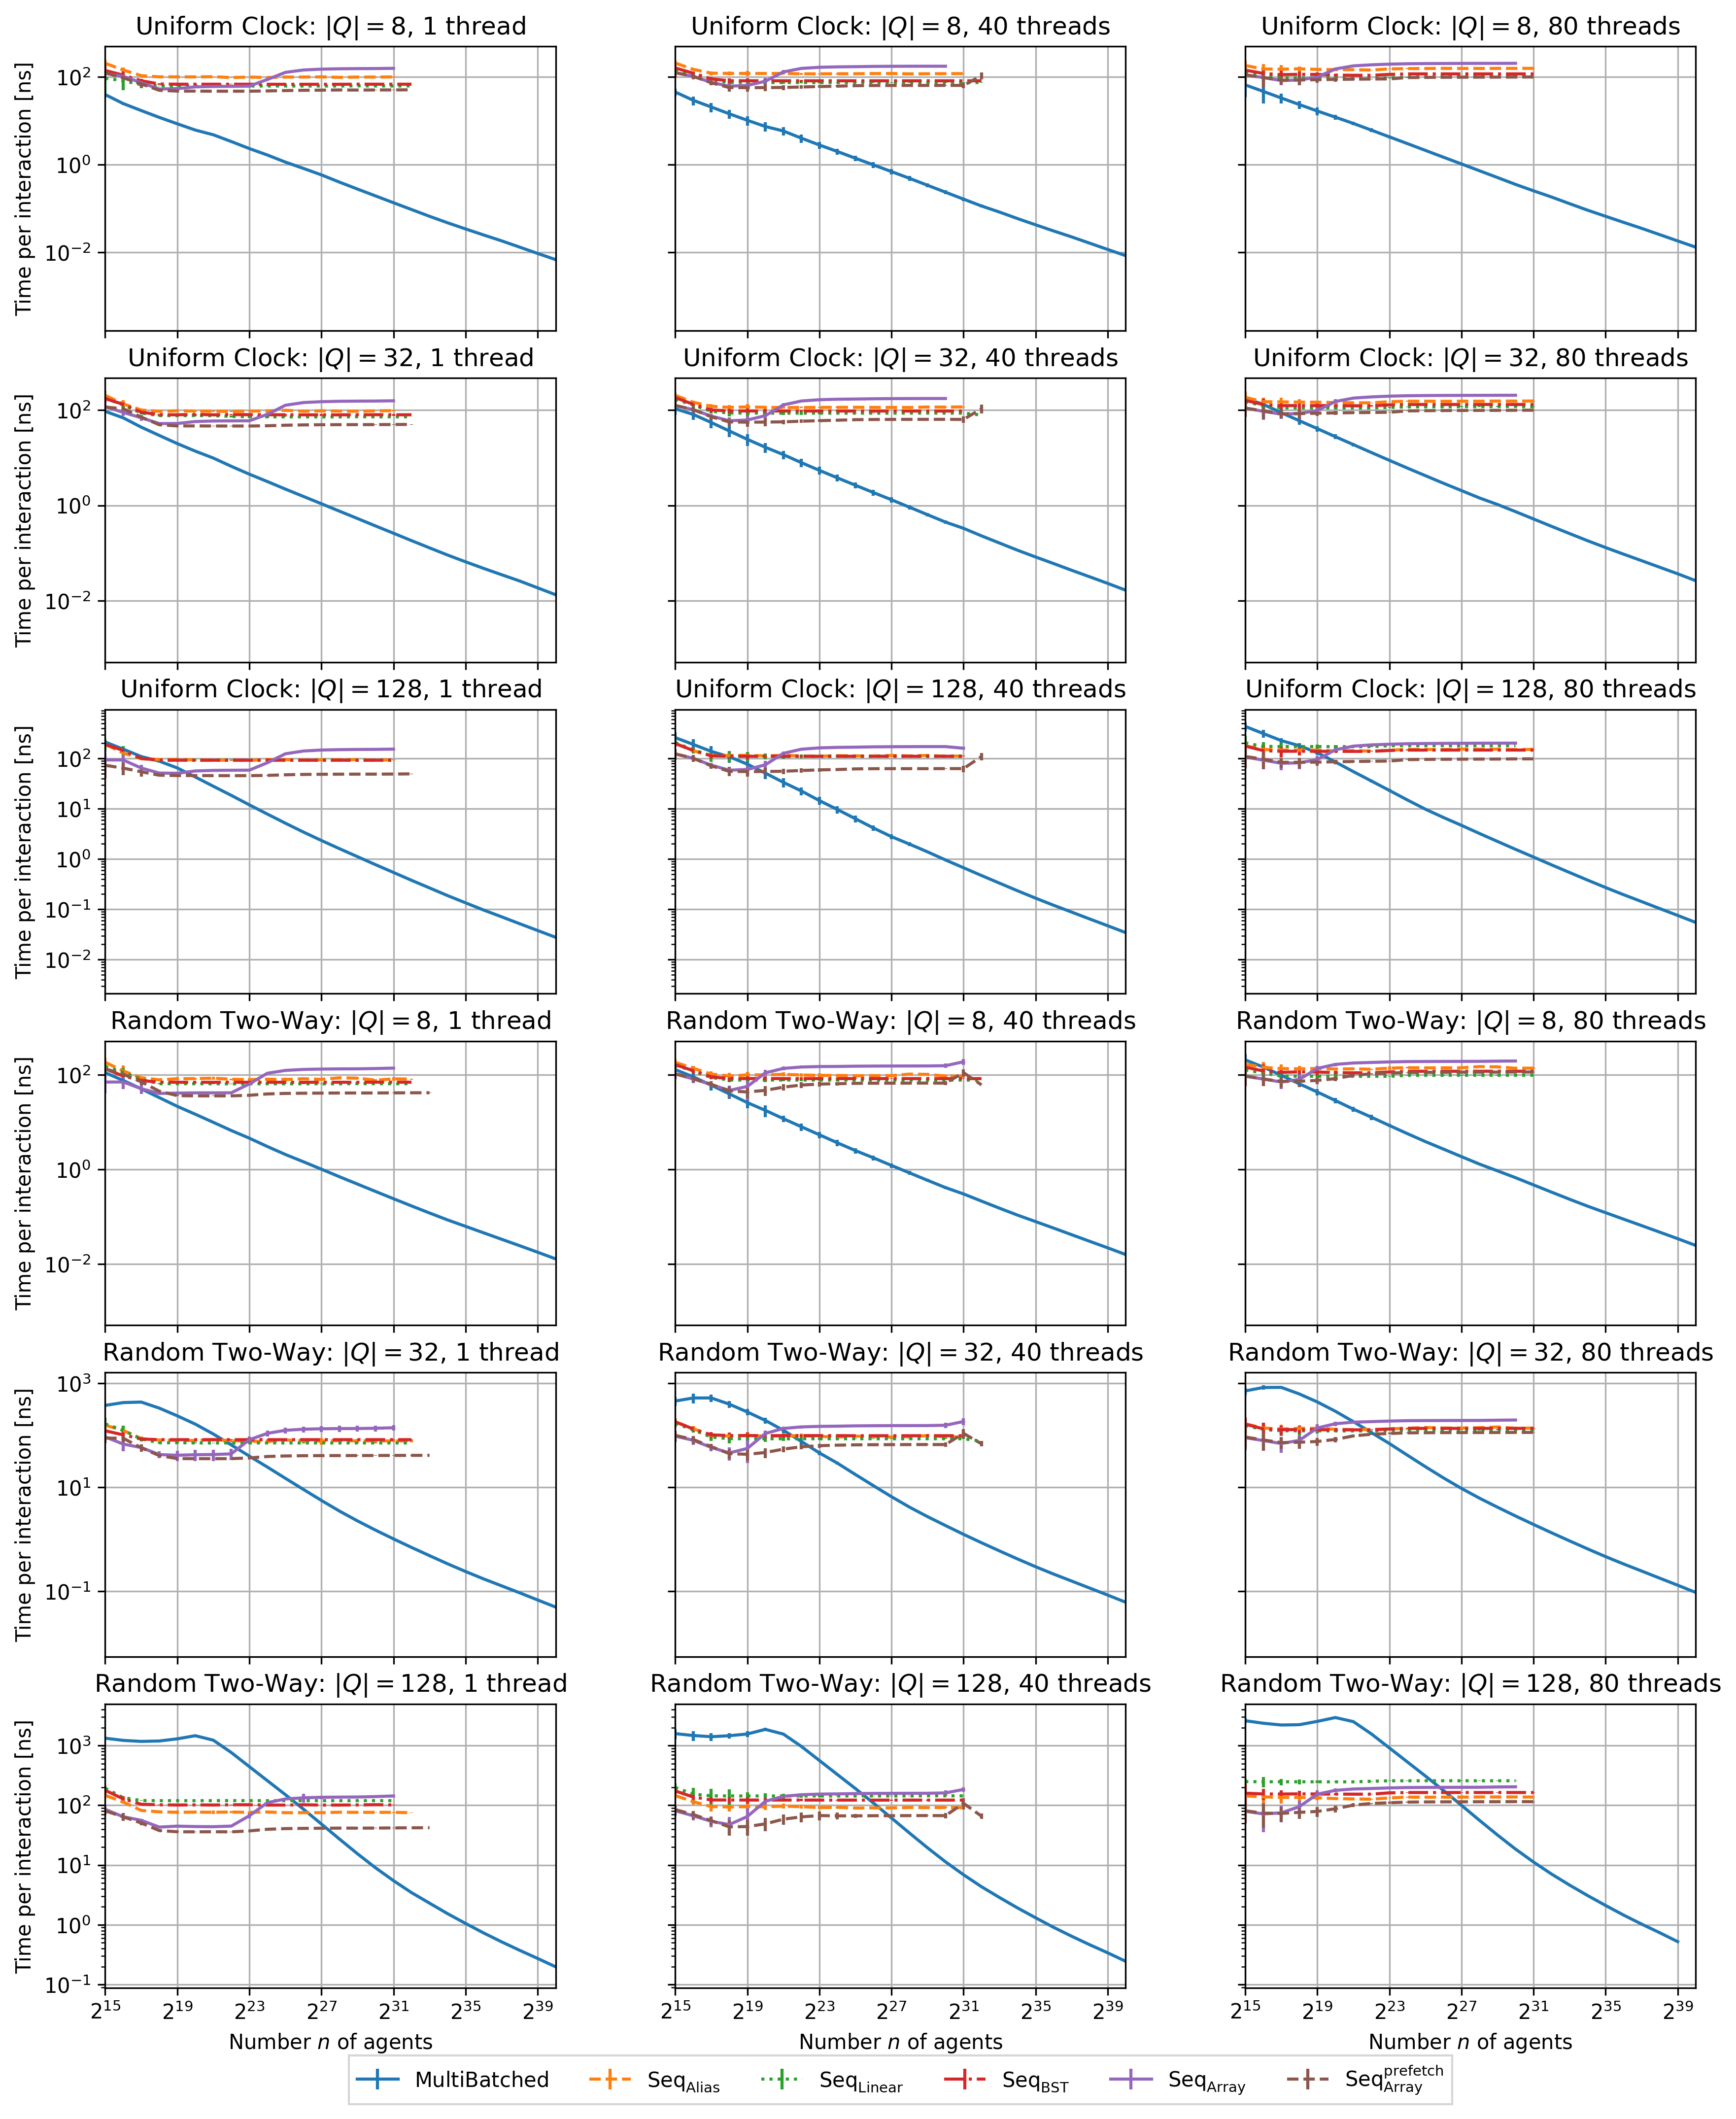

In [5]:
def plot_grid(data, incl_batch):
    # Overview
    cols = len(data.threads.unique())
    rows = len(data.protocol.unique()) * len(data.num_states.unique())

    fig, axs = plt.subplots(rows, cols, sharey = "row", sharex="all", figsize=(4*cols, 3*rows), dpi=300)

    for row_id, ((protocol, num_states), ps_view) in enumerate(data.groupby(["protocol", "num_states"])):
        for col_id, (threads, t_view) in enumerate(ps_view.groupby("threads")):
            ax = axs[row_id, col_id]
            plot_benchmark(t_view, protocol, num_states, threads, ax, incl_batch,
                           incl_xlabels=(row_id + 1== rows),
                           incl_ylabels=(col_id == 0))

    fig.tight_layout()
    add_sublegend(fig, axs)
    
    return fig, axs

fig, axs = plot_grid(data, False)
fig.savefig(os.path.join(OUTDIR, "benchmark_grid_wo_batch.pdf"), bbox_inches='tight')

fig, axs = plot_grid(data, True)
fig.savefig(os.path.join(OUTDIR, "benchmark_grid_with_batch.pdf"),  bbox_inches='tight')





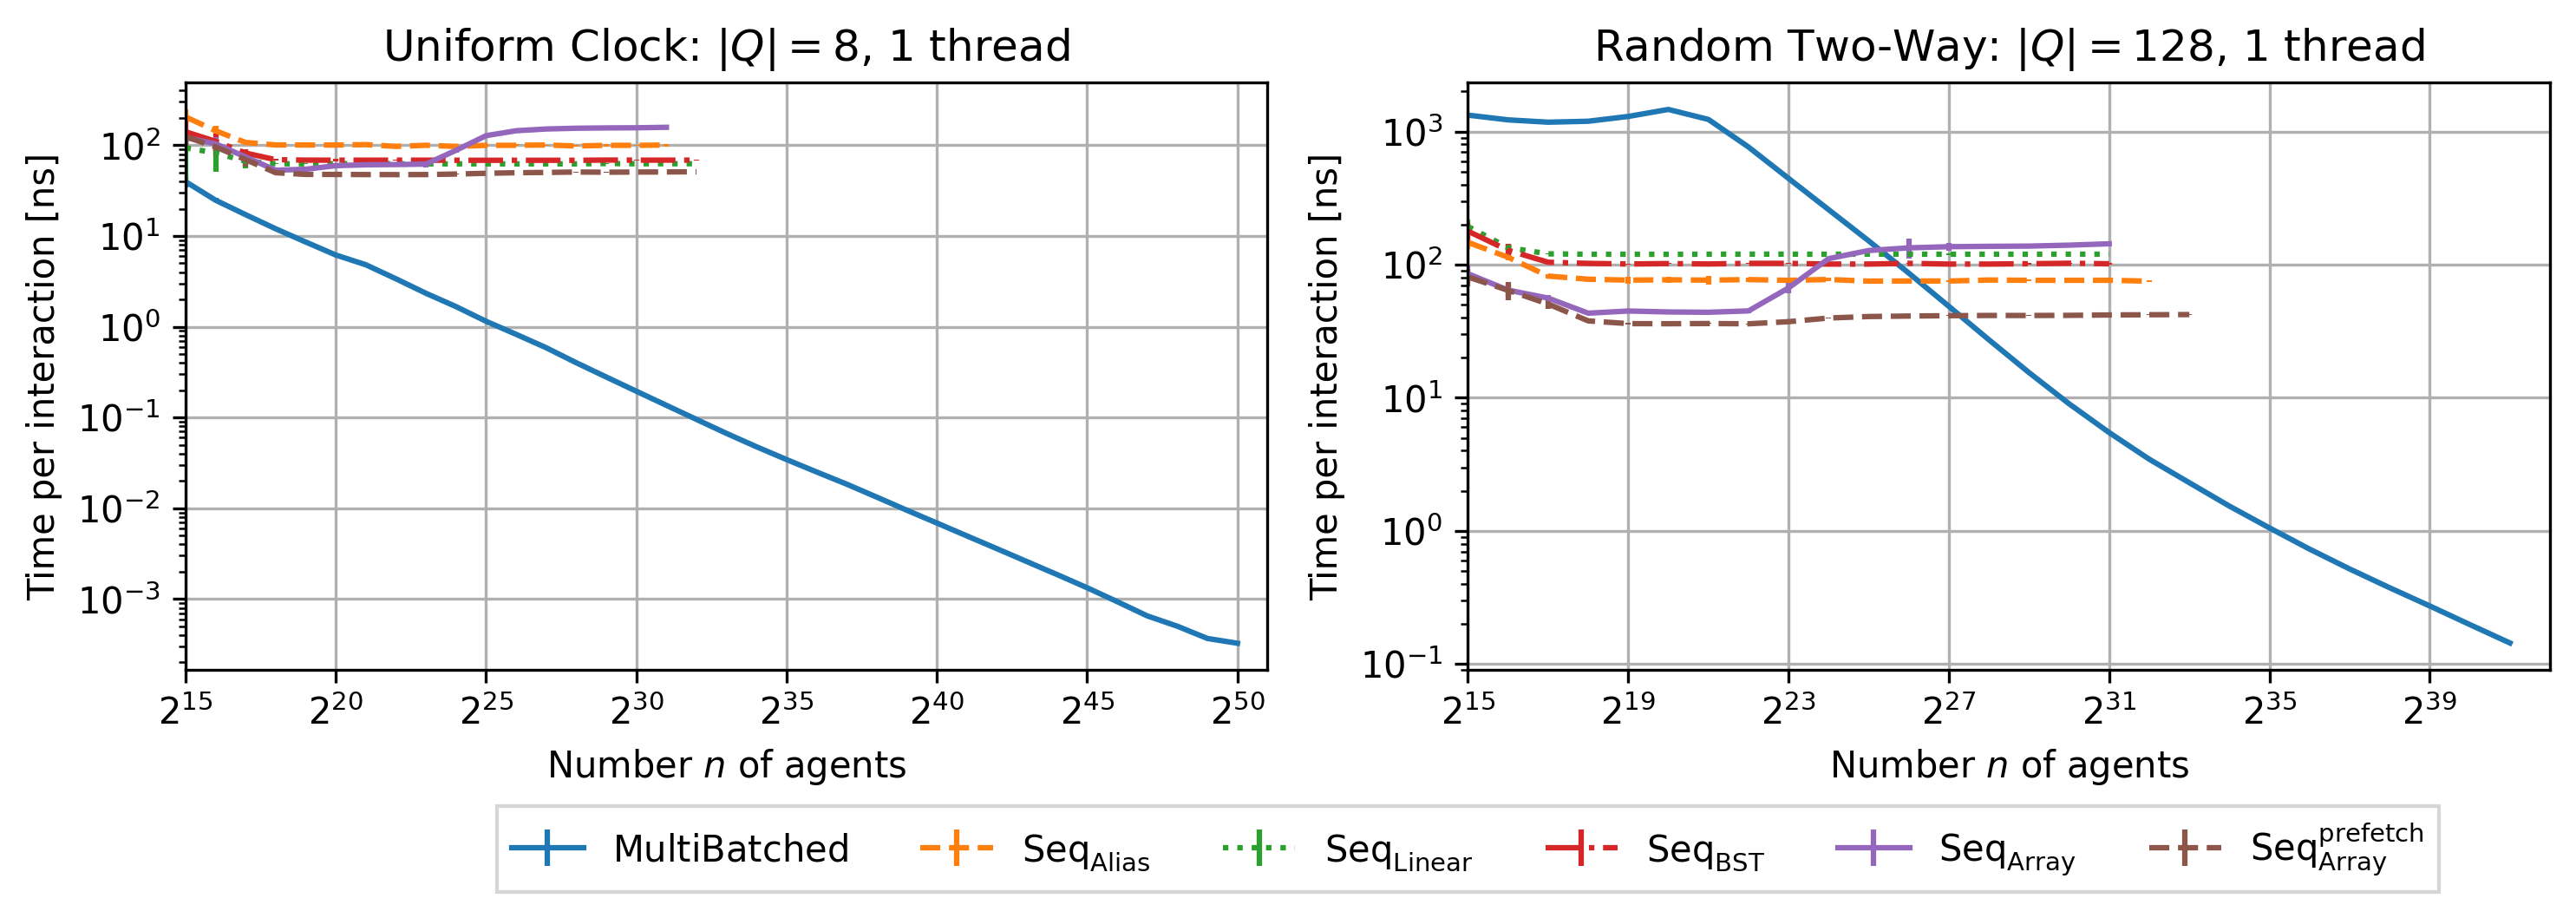

In [6]:
def plot_selection_batch(data):
    rows, cols = 1, 2
    fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 3.5*rows), dpi=300)

    for (protocol, num_states, threads), view in data.groupby(["protocol", "num_states", "threads"]):
        if   protocol == "clock"   and num_states ==   8 and threads ==  1: col = 0
        elif protocol == "random2" and num_states == 128 and threads ==  1: col = 1
        else: continue
        
        plot_benchmark(view, protocol, num_states, threads, axs[col], True,
                       incl_xlabels=True, incl_ylabels=True, timeout=400)


    fig.tight_layout()
    add_sublegend(fig, axs)
    
    return fig, axs

fig, axs = plot_selection_batch(data)
fig.savefig(os.path.join(OUTDIR, "benchmark_selection_batch.pdf"), bbox_inches='tight')

simulator
batch                  0.342411
distr-alias-fixed     77.022310
distr-linear          64.968663
distr-tree            69.887945
pop                  135.738917
pop8                  41.305690
Name: int_time, dtype: float64
simulator
batch                0.010303
distr-alias-fixed    2.356349
distr-linear         1.934815
distr-tree           2.078711
pop                  3.896302
pop8                 1.668843
Name: int_time, dtype: float64
simulator
batch                0.008363
distr-alias-fixed    1.722743
distr-linear         1.225176
distr-tree           1.488400
pop                  2.449536
pop8                 1.433139
Name: int_time, dtype: float64


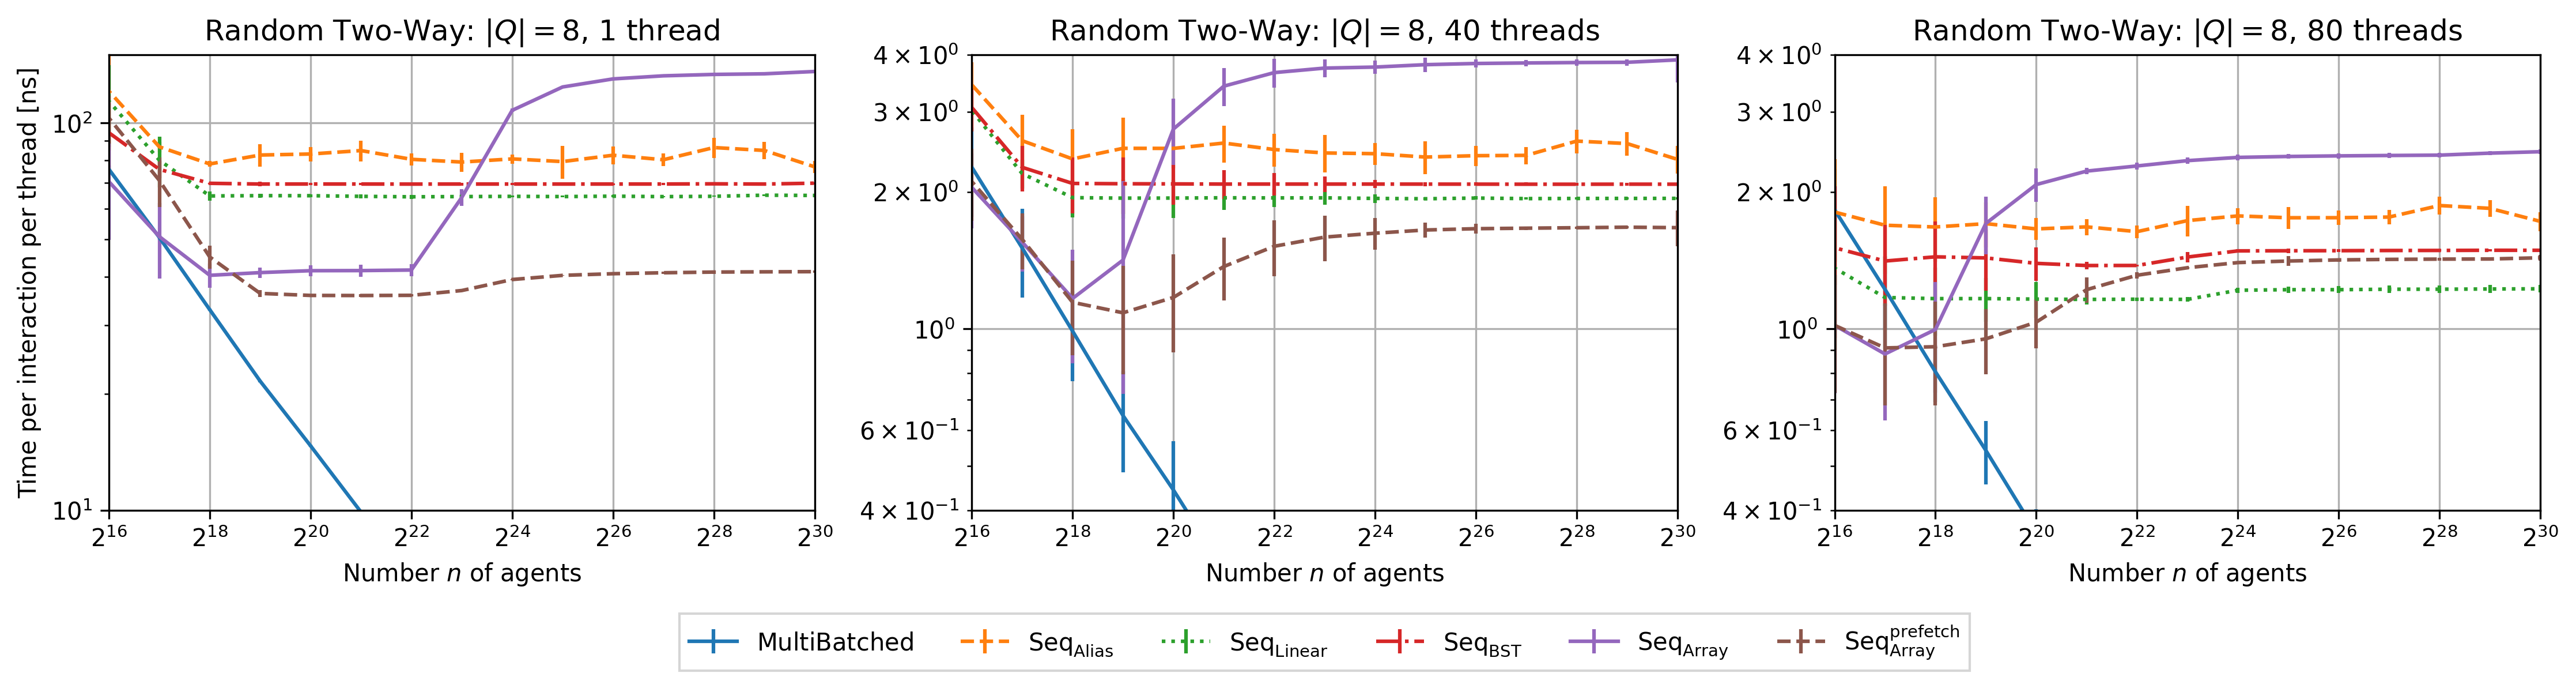

In [7]:
def plot_selection_batch(data):
    rows, cols = 1, 3
    fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), dpi=300)
    
    col = 0
    for (protocol, num_states, threads), view in data.groupby(["protocol", "num_states", "threads"]):
        if not (protocol == "random2" and num_states == 8): continue
        
        plot_benchmark(view, protocol, num_states, threads, axs[col], True,
                       incl_xlabels=True, incl_ylabels=(col==0), timeout=10000)
        
        axs[col].set_xlim(2**16, 2**30)
        #axs[col].set_yscale('linear')
        #axs[col].set_ylim(0, 220)
        #axs[col].set_ylim(0.1, 200)
        if col == 0:
            axs[col].set_ylim(10, 150)
            axs[col].set_ylabel("Time per interaction per thread [ns]")
        else:
            axs[col].set_ylim(0.4, 4)
        
        
        tdata = view[view.num_agents == 2**30]
        grp = tdata.groupby("simulator")
        print(grp.int_time.median())
        
        
        col += 1


    fig.tight_layout()
    add_sublegend(fig, axs)
    
    return fig, axs

threaded_data = data[:]
threaded_data.int_time = 1e9 * data.walltime / data.num_interactions / data.threads
fig, axs = plot_selection_batch(threaded_data)
fig.savefig(os.path.join(OUTDIR, "benchmark_selection_threading.pdf"), bbox_inches='tight')

In [8]:
#self speedups
base = None

for (protocol, num_states, threads), view in threaded_data.groupby(["protocol", "num_states", "threads"]):
    if not (protocol == "random2" and num_states == 8): continue
        
    tdata = view[view.num_agents == 2**30]
    grp = tdata.groupby("simulator")
    ys = grp.int_time.median()
    
    if threads == 1:
        base = ys
    else:
        print("\n Threads:", threads)
        print(base / ys)
    



 Threads: 40
simulator
batch                33.234193
distr-alias-fixed    32.687143
distr-linear         33.578750
distr-tree           33.620802
pop                  34.837885
pop8                 24.751093
Name: int_time, dtype: float64

 Threads: 80
simulator
batch                40.942540
distr-alias-fixed    44.709116
distr-linear         53.028039
distr-tree           46.955079
pop                  55.414124
pop8                 28.821821
Name: int_time, dtype: float64


clock
                 batch:  0.1994 0.9973 5.0029 0.6595
     distr-alias-fixed:  110.7485 116.5099 1.0520 112.5951
          distr-linear:  63.1449 103.1438 1.6334 89.6638
            distr-tree:  74.2936 112.7782 1.5180 104.9528
                   pop:  170.0309 174.8358 1.0283 170.9703
                  pop8:  59.1518 60.8988 1.0295 59.7048
random2
                 batch:  0.2188 8.8892 40.6298 4.0814
     distr-alias-fixed:  95.5004 101.0005 1.0576 97.6252
          distr-linear:  69.2913 126.9804 1.8326 100.6087
            distr-tree:  72.9922 121.7154 1.6675 110.8462
                   pop:  152.2806 163.0346 1.0706 155.6674
                  pop8:  61.1766 62.2671 1.0178 61.4276
running-clock
                 batch:  0.1340 0.1397 1.0421 0.1367
     distr-alias-fixed:  111.7337 122.9493 1.1004 112.9117
          distr-linear:  46.4555 46.4936 1.0008 46.4783
            distr-tree:  64.6544 107.1406 1.6571 99.0689
                   pop:  153.3795 156.7843 1.0222 154.0646
    

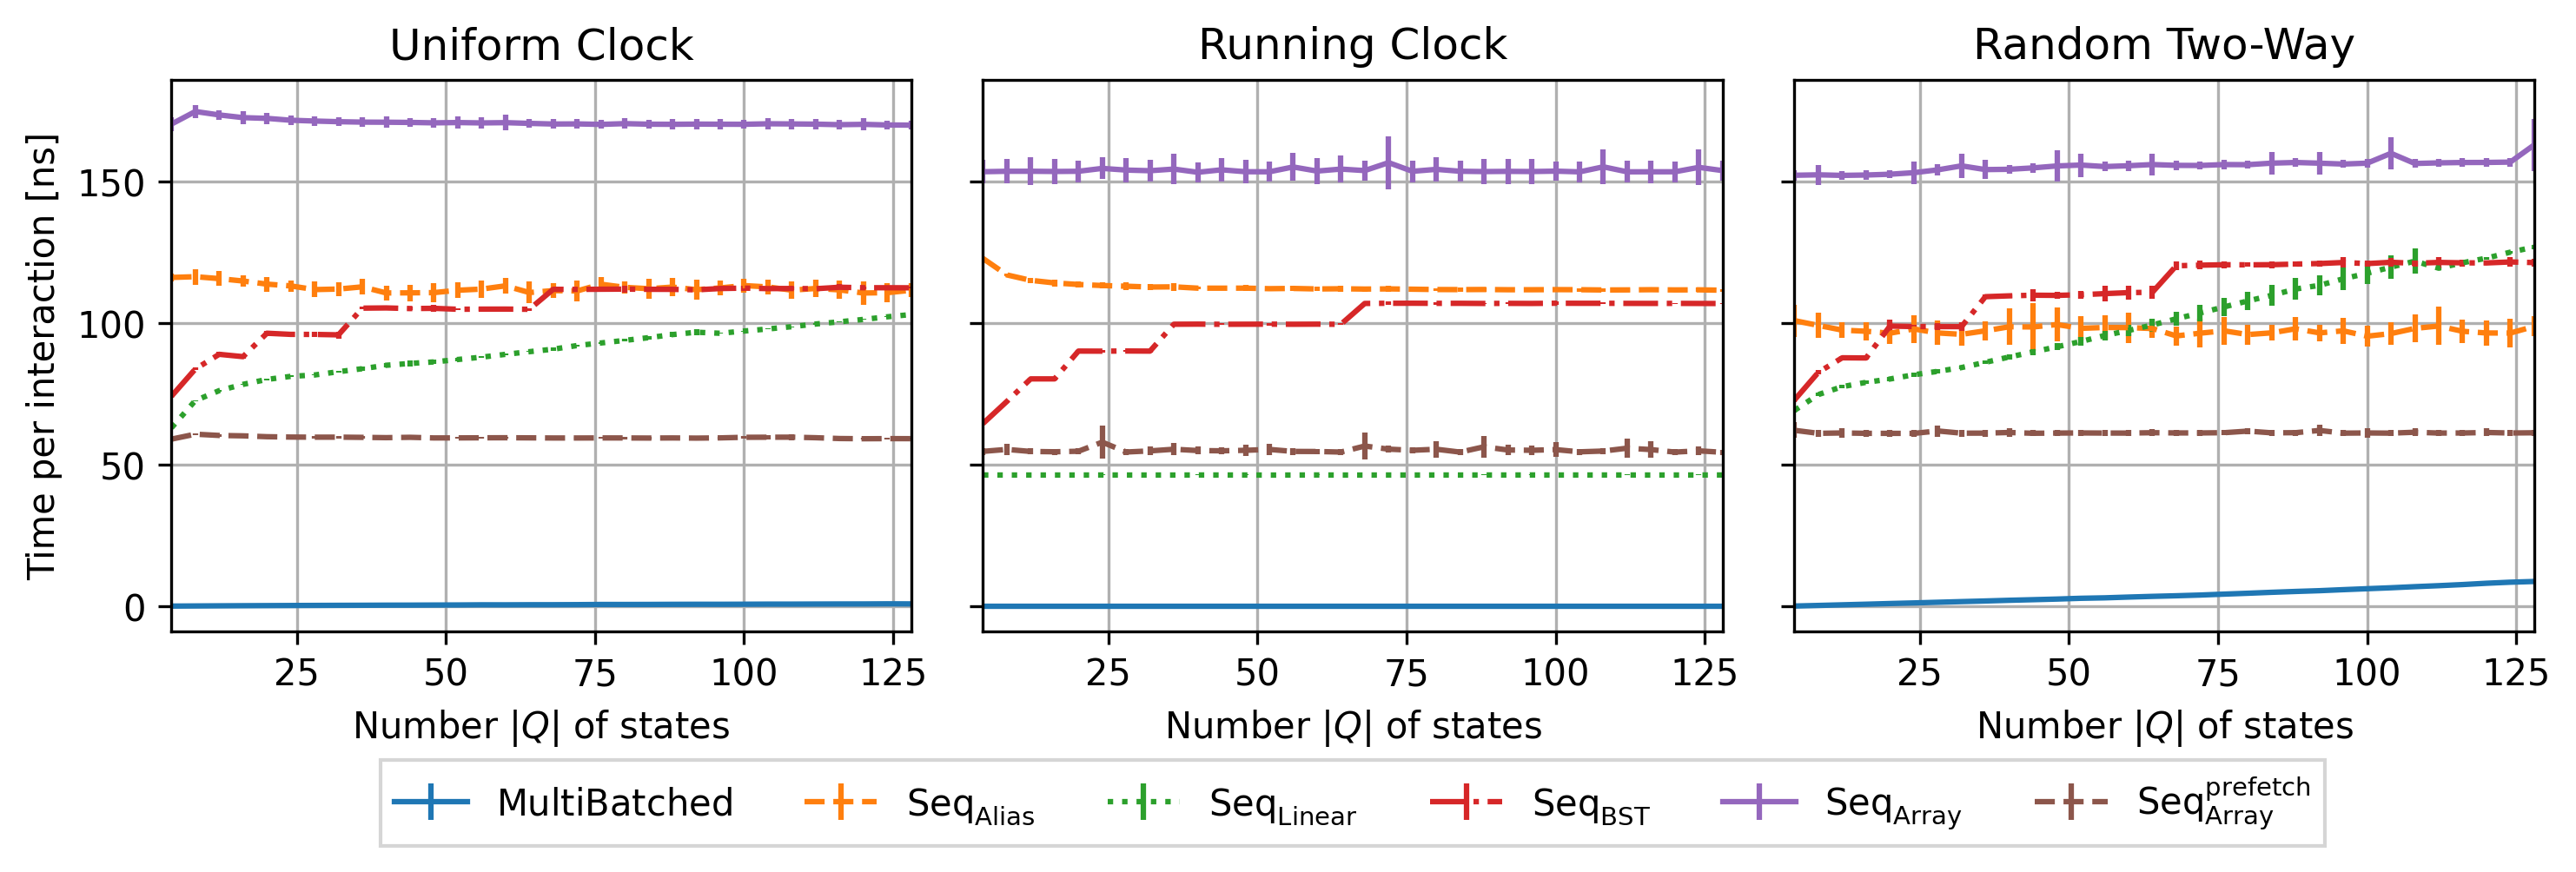

In [9]:
data = pd.read_csv("data/threaded_benchmark_states.csv.bz2")
data = data[data.simulator != "distr-alias"]
data["int_time"] = 1e9 * data.walltime / data.num_interactions

prots = sorted(data.protocol.unique())
fig, axs = plt.subplots(
    1, len(prots),
    sharey=True,
    figsize=(10, 3.3), dpi=300
)

plot_order = [0, 2, 1]

for pid, (prot, pview) in enumerate(data.groupby("protocol")):
    ax = axs[plot_order[pid]]
    print(prot)
    for sim, sview in pview.groupby("simulator"):
        grp = sview.groupby("num_states")
        ys     = grp.int_time.mean()
        ys_err = grp.int_time.std()
        xs     = ys.index
        
        print("  % 20s: % 4.4f %4.4f %4.4f %.4f" % (sim, np.min(ys), np.max(ys), np.max(ys) / np.min(ys), np.mean(ys)))

        ax.errorbar(xs, ys, ys_err, label=renameSim(sim), **styleSim(sim))
    
    ax.set_title(renameProtocol(prot))
    ax.grid()
    ax.set_xlabel("Number $|Q|$ of states")
    ax.set_xlim(4, 128)
    if pid == 0: 
        ax.set_ylabel("Time per interaction [ns]")

fig.tight_layout()
add_sublegend(fig, axs)

fig.savefig("/home/manpen/Documents/ae/pubs/popprotsim/paper/figures/benchmark_states.pdf", bbox_inches='tight')
